# 每年度单一机构持仓变化率TOP5（正负两种）

BRK

In [1]:
import pandas as pd
import numpy as np
import glob,os
import matplotlib
import matplotlib.pyplot as plt

In [2]:
file = glob.glob(os.path.join("brk-13F/000106798313F-HR12-31-20??.csv"))
print(len(file))

8


In [3]:
dl = []
for f in file:
    dlTemp = pd.read_csv(f, usecols=['Name of Issuer', 'Value', 'Date'])
    dl.append(dlTemp)

dlTotal = pd.concat(dl, ignore_index=True)

In [4]:
dlTotal = dlTotal.replace(regex=r'^CHARTER COMMUNICATIONS INC .*$', value='CHARTER COMMUNICATIONS INC').replace(regex=r'^MEDIA GEN INC .*$', value='MEDIA GEN INC')

In [5]:
dlGrouped = dlTotal.groupby(by=['Date', 'Name of Issuer']).sum().reset_index()

In [6]:
dates = list(dlGrouped['Date'].unique())
names = list(dlGrouped['Name of Issuer'].unique())

In [7]:
dlFull = pd.DataFrame(columns=['Date', 'Name of Issuer'])
for date in dates:
    for name in names:
        dlFull = dlFull.append({'Date': date, 'Name of Issuer': name, 'Value': 0}, ignore_index=True)

In [8]:
print(len(dlFull), len(dlGrouped))

672 357


In [9]:
dlFinal = pd.concat([dlGrouped, dlFull]).drop_duplicates(keep='first')
dlFinal = dlFinal.replace(regex=r'-12-31$', value='')

In [10]:
dlPivot = dlFinal.pivot_table(values='Value', index=dlFinal.Date, columns='Name of Issuer', aggfunc='first').reset_index()

In [11]:
columns = list(dlPivot.columns[1:])
dlPivotRate = pd.DataFrame(dlPivot['Date'])
for col in columns:
    dlThis = dlPivot[col]
    dlLater = dlThis[1:].reset_index(drop=True).append(dlThis[-1:])
    dlPivotRate[col] = (dlLater - dlThis) / dlThis

In [12]:
dlPivotRateFormat = dlPivotRate.fillna(0).replace(np.inf, 1)
dlPivotRateFormat.head(5)

,Date,ABBVIE INC,AMAZON COM INC,AMERICAN AIRLS GROUP INC,AMERICAN EXPRESS CO,APPLE INC,AT&T INC,AXALTA COATING SYS LTD,BANK AMER CORP,BANK OF NEW YORK MELLON CORP,...,US BANCORP DEL,VANGUARD INDEX FDS,VERISIGN INC,VERISK ANALYTICS INC,VERIZON COMMUNICATIONS INC,VIACOM INC NEW,VISA INC,WABCO HLDGS INC,WAL MART STORES INC,WELLS FARGO & CO NEW
0,2013,0.0,0.0,0.000000,0.025460,0.000000,0.0,0.000000,0.00000,0.036779,...,0.123475,0.0,0.129510,-0.025411,1.000000,-0.022108,0.899518,0.121719,0.331806,0.207489
1,2014,0.0,0.0,0.000000,-0.252472,0.000000,1.0,1.000000,0.00000,-0.071691,...,0.008165,0.0,0.532632,0.200314,-0.011970,-1.000000,0.165150,-0.202443,-0.335859,0.026369
2,2015,0.0,0.0,1.000000,0.065133,1.000000,-1.0,0.020638,0.00000,0.238584,...,0.203890,0.0,-0.131399,0.055800,-0.999928,0.000000,0.074993,0.049626,-0.972034,0.013797
3,2016,0.0,0.0,0.125507,0.340578,3.211622,0.0,0.189706,1.00000,2.190144,...,0.067492,0.0,0.504404,0.182705,-0.020000,0.000000,0.461421,-1.000000,0.428675,0.051612
4,2017,0.0,0.0,-0.413713,-0.040177,0.407111,0.0,-0.247099,0.10165,0.163025,...,0.266860,0.0,0.295789,-1.000000,0.061224,0.000000,0.157165,0.000000,-1.000000,-0.292632


In [13]:
dlSelected = dlPivotRateFormat[:-1]
dlSelectedT = dlSelected.set_index(keys=['Date'], drop=True).T

In [14]:
dlSelectedT = dlSelectedT * 100

In [15]:
dates = dlSelectedT.columns

In [16]:
num = 5
cols = ['Date']
for i in range(num): 
    cols.append('Name' + str(i+1))
    cols.append('Value' + str(i+1))
dlResTop5 = pd.DataFrame(columns=cols)
dlResLast5 = pd.DataFrame(columns=cols)

In [17]:
nameListTop = []
nameListLast = []
maxValue = 0
minValue = 0
for date in dates:
    dlLast5 = dlSelectedT[date].sort_values().head(num)
    dlTop5 = dlSelectedT[date].sort_values(ascending=False).head(num)

    rowTop = [date]
    for key in dlTop5.index:
        nameListTop.append(key)
        if dlTop5[key] > maxValue:
            maxValue = dlTop5[key]
        rowTop.append(key)
        rowTop.append(dlTop5[key])
    dlResTop5 = dlResTop5.append(pd.DataFrame([rowTop], columns=cols), ignore_index=True)

    rowLast = [date]
    for key in dlLast5.index:
        nameListLast.append(key)
        if dlLast5[key] < minValue:
            minValue = dlLast5[key]
        rowLast.append(key)
        rowLast.append(dlLast5[key])
    dlResLast5 = dlResLast5.append(pd.DataFrame([rowLast], columns=cols), ignore_index=True)

In [18]:
nameSetTop = list(set(nameListTop))
nameSetLast = list(set(nameListLast))

In [19]:
colors = [plt.cm.Spectral(i/float(len(nameSetTop)-1)) for i in range(len(nameSetTop))]
def getColorTop(names): 
    res = []
    for name in names:
        index = nameSetTop.index(name)
        res.append(colors[index])
    
    return res

def getColorLast(names): 
    res = []
    for name in names:
        index = nameSetLast.index(name)
        res.append(colors[index])
    
    return res

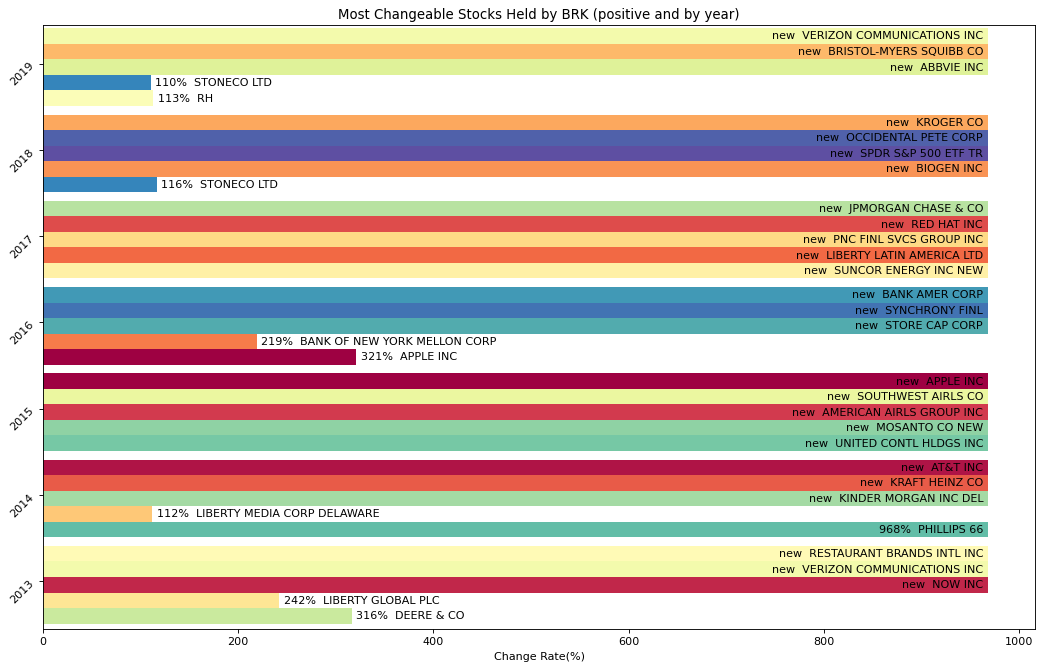

In [25]:
# Draw
fig, ax = plt.subplots(1,1,figsize=(16, 10), dpi= 80)  

y_range = np.arange(len(dlResTop5)) + 0.15
width = 0.18

for i in range(num):
    ax.barh(y=y_range, width=dlResTop5['Value'+str(i+1)].replace(100, maxValue),  color=getColorTop(dlResTop5['Name'+str(i+1)].values), tick_label=dlResTop5['Date'], height=width)
    for j in range(len(dlResTop5)):
        value =dlResTop5['Value'+str(i+1)][j]
        interval = maxValue / 200
        if value > maxValue / 2 or value==100:
            ax.text(maxValue-interval if value==100 else value-interval, y_range[j]-0.03, s=('new' if value==100 else str(round(value))+'%') + '  ' + dlResTop5['Name'+str(i+1)][j], ha='right')
        else:
            ax.text(maxValue+interval if value==100 else value+interval, y_range[j]-0.03, s=('new' if value==100 else str(round(value))+'%') + '  ' + dlResTop5['Name'+str(i+1)][j], ha='left')

    y_range = y_range + width

ax.set(xlabel='Change Rate(%)',
       title="Most Changeable Stocks Held by BRK (positive and by year)")

# ax.legend(loc='best', fontsize=12)

plt.yticks(y_range-0.5, dates, rotation=45)
plt.ylim(0, len(dlResTop5))

fig.savefig("Most_Changeable_Stocks_Held_by_BRK_3.png")
plt.show()

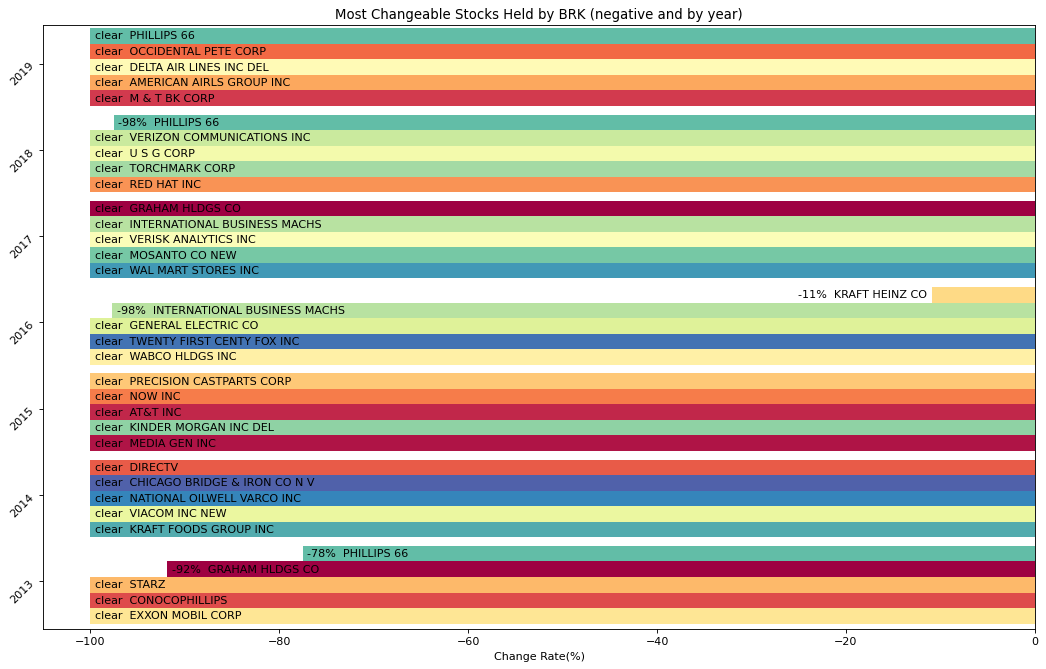

In [26]:
# Draw
fig, ax = plt.subplots(1,1,figsize=(16, 10), dpi= 80)  

y_range = np.arange(len(dlResLast5)) + 0.15
width = 0.18

for i in range(num):
    ax.barh(y=y_range, width=dlResLast5['Value'+str(i+1)].replace(100, minValue),  color=getColorLast(dlResLast5['Name'+str(i+1)].values), tick_label=dlResLast5['Date'], height=width)
    for j in range(len(dlResLast5)):
        value =dlResLast5['Value'+str(i+1)][j]
        interval = minValue / 200
        if value < minValue / 2 or value==-100:
            ax.text(minValue-interval if value==-100 else value-interval, y_range[j]-0.03, s=('clear' if value==-100 else str(round(value))+'%') + '  ' + dlResLast5['Name'+str(i+1)][j], ha='left')
        else:
            ax.text(minValue+interval if value==-100 else value+interval, y_range[j]-0.03, s=('clear' if value==-100 else str(round(value))+'%') + '  ' + dlResLast5['Name'+str(i+1)][j], ha='right')

    y_range = y_range + width

ax.set(xlabel='Change Rate(%)',
       title="Most Changeable Stocks Held by BRK (negative and by year)")

# ax.legend(loc='best', fontsize=12)

plt.yticks(y_range-0.5, dates, rotation=45)
plt.ylim(0, len(dlResLast5))

fig.savefig("Most_Changeable_Stocks_Held_by_BRK_4.png")
plt.show()